# Probing for an Empirical Formula for Transmitted E for Gaussian Beams
#  Concentrating on $\Phi$

## Summary:

$$J(x,y):=\frac{2E_p}{\pi w^2}e^{\frac{-2}{w^2}(x^2 + y^2)}$$
$$\Delta J(J):= J(\alpha_0+\frac{\alpha_s}{1+J/J_s})$$
Properties of graphene: $$J_s = 0.00000015\text{ } \text{uJum}^{-2}, \alpha_0 = 0.01725, \alpha_s=0.00575$$
Experimental setup values: $$E_p \approx 0.0003\text{ } \text{uJ}, w=34\text{ } \text{um}$$
We could start off by focusing on the following approximation for miniscule stripe thicknesses:
$$E_{tot} \approx^{?}  \%_{grp}\cdot\iint_{-\infty}^{\infty}(J-\Delta J)dxdy + \%_{abl} \cdot\iint_{-\infty}^{\infty}Jdxdy = E_p - \%_{grp} \iint_{-\infty}^{\infty}\Delta Jdxdy$$

In [1]:
from beam import *
from sympy import *
from scipy import integrate
init_printing(use_unicode=True, use_latex=True)

In [2]:
x,y = symbols('x,y')
E_p,a_0,a_s,J_s,E_tot,p_grp,p_abl,w = symbols('E_p,a_0,a_s,J_s,E_tot,p_grp,p_abl,w', positive=True)
J = S(2)*E_p*exp((-2/(w**2))*(x**2 + y**2))/(pi*(w**2))
J_red = J*(a_0+(a_s)/(S(1) + J/J_s))

# The experimental setup had the following parameters:
J_exp = J.subs({w:34,E_p:0.0003})
J_red_exp = J_red.subs({a_0:0.01725,a_s:0.00575,J_s:0.00000015,w:34,E_p:0.0003})
# numpy functions for J_exp and J_red_exp:
npJ_exp = lambdify((x,y), J_exp, 'numpy')
npJ_red_exp = lambdify((x,y), J_red_exp, 'numpy')
# numpy function for J transmitted through graphene:
npJ_aftermath_exp = lambdify((x,y), J_exp-J_red_exp, 'numpy')

# E_tot approximation(p_grp) for miniscule stripes case, for experimental setup:
E_tot_ministripes_exp = lambda x: (0.0003 - np.multiply((x/100), integrate.nquad(npJ_red_exp,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]))

# Initializing a Gaussian beam with the experimental setup values:
beam_exp = beam_initialize(Ep=0.0003,threshold=10**-12,res=30,w=34)

In [3]:
# Now we can check up to what thickness this approximation holds with some acceptable error
# We can also see if there is some easy way to calculate the fluctuations for this case and may be able to extend it to other cases

# Let us define the following function to ease the process:

def fluctuation_checker(beam, width_config):  # width_config is a list with entries: [d_grp, d_abl]
    results = []  # results list will contain energy integral values(wrt offset 1um per step) of each config
    Einput_actual = integrate_for_energy(beam)

    for i in range(len(width_config)):
        mm = mask_initialize(beam=beam, shape='lines', width=width_config[i][0], thickness=width_config[i][1], crop=False)
        stepsize = int(np.ceil(width_config[i][0] + width_config[i][1]))
        itrtr = mask_slide_iterator(beam=beam,mask=mm,stepsY=stepsize)  # Slider slides graphene layer about 1um at a time
        tmp = []
        for j in itrtr:
            k = integrate_for_energy(j[1])
            tmp.append(k)
            del(j)
        results.append(tmp)
        del(mm)
        del(itrtr)

    dE_E = []  # dE_E will hold loss% values calculated from the results list
    for i in range(len(width_config)):
        dE_E.append([(100*(Einput_actual - j)/Einput_actual) for j in results[i]])  # 100*2*ΔE/E values are calculated, x2 is needed as the beam passes through the mask twice, the effect caused by the energy drop before the second pass is neglected
    for i in range(len(width_config)):
        plt.plot(dE_E[i], label=f"{(width_config[i][0],width_config[i][1])} um")
    plt.ylabel('Loss (%)')
    plt.xlabel('Sliding Offset (um)')
    plt.legend(loc = 'best')
    plt.show()


    dE_E_diff = [100*(max(i)-min(i))/((sum(i))/len(i)) for i in dE_E]
    # I change this part constantly depending on the situation to make the graphs more explanatory:
    plt.plot([100*width_config[i][0]/(width_config[i][0]+width_config[i][1]) for i in range(len(width_config))], dE_E_diff,'o')
    plt.ylabel(r'% Change in Loss over Mean Loss')
    plt.xlabel('Graphene %')
    #####
    plt.show()
    
    return dE_E_diff

## Hypothesis:
$$E_{after} \approx \Phi(d_{grpwidth})\cdot\sin(2\pi \frac{x}{d_{totwidth}}) + E_p - G_{\%} \iint_{-\infty}^{\infty}\Delta Jdxdy,$$
$$\text{where }\Phi \text{ is some function, may be dependant on $G_{\%}$ (graphene percentage) and $w$ as well, x offset wrt pad init}$$

There seems to be a region where the fluctuations are negligible (where $d_{totwidth} < w$ maybe??), and then the fluctuation range linearly increases as we widen the stripes.

After some more tinkering, we could infer that fluctuation is negligible for any $E_p$ value if the total width of a period ($d_{totwidth}$, which is $d_{grp} + d_{abl}$) does not exceed $w$, and this may hold even for materials other than graphene, which may have different $\alpha_0,\alpha_s,J_s$ values.

There may be a third region of interest for % change in loss over mean loss. The first one is for the $d_{totwidth} < w$ case, at which the fluctuation is negligible, then there comes a linear increase in fluctuation range, and a third region may arise, or the second region may be actually logarithmic that looks linear when $d_{totwidth} < c\cdot w$, c may be a constant or some function.

We can see that for $E_p=0.0003\text{uJ},w=17\text{um}$, we get negligible fluctuation for $d_{totwidth} < w$ and a linear increase in fluctuation for about $w < d_{totwidth} < 3w$. Up to this point, we can see that keeping $d_{totwidth}$ below $w$ is good for getting a non-fluctuating $E_{after}$ reading.

## End of summary

# Finding $\Phi$:

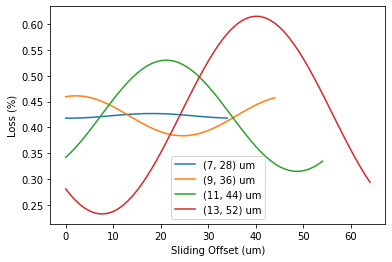

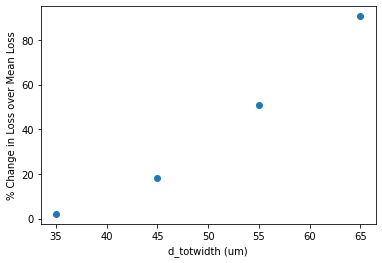

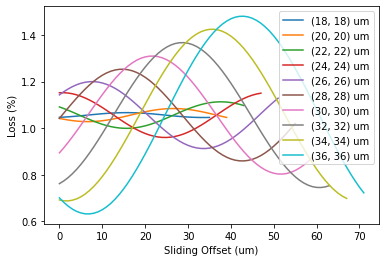

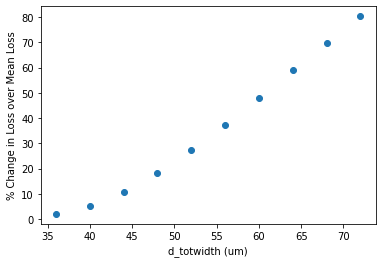

In [4]:
# Let us find a candidate for Phi that fits for beam_exp--> E_p=0.0003uJ, w=34um where d_tot between w, 2w
# Will look at how the dependent variable 'change in loss over mean loss' behaves under certain conditions
# Using one pass only, loss is not multiplied by two unlike most cases up to now, which accounted for the double pass of the experimental setup


# Let us see two cases:
zegsa_20pc_beam_exp_pcchangeinloss = fluctuation_checker(beam_exp,[[i,4*i] for i in range(7,14,2)])
zegsa_50pc_beam_exp_pcchangeinloss = fluctuation_checker(beam_exp,[[i,i] for i in range(18,38,2)])

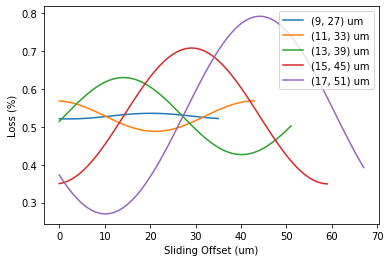

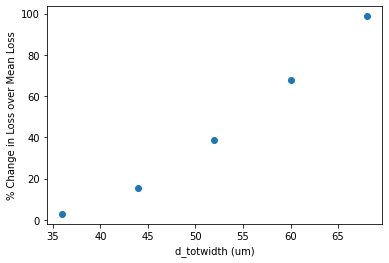

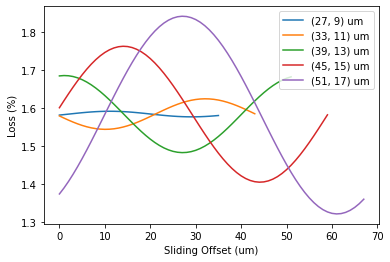

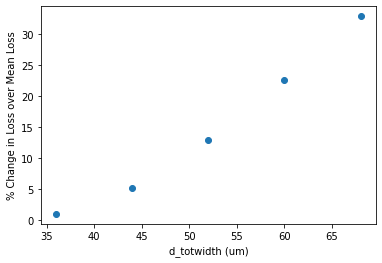

In [5]:
# Let us compare two opposite configurations (total width same, graphene and ablation thicknesses swapped)

zegsa_25pc_beam_exp_pcchangeinloss = fluctuation_checker(beam_exp,[[i,3*i] for i in range(9,18,2)])
zegsa_75pc_beam_exp_pcchangeinloss = fluctuation_checker(beam_exp,[[3*i,i] for i in range(9,18,2)])

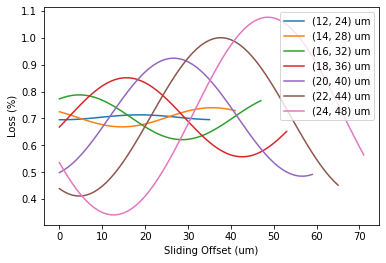

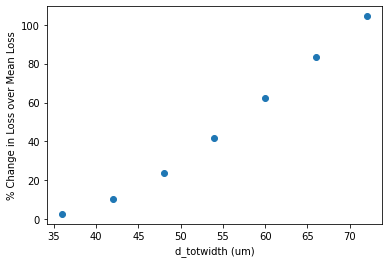

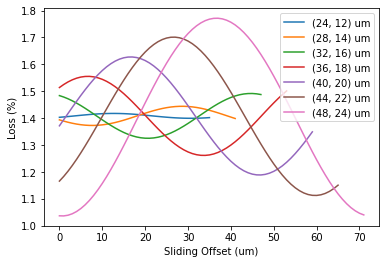

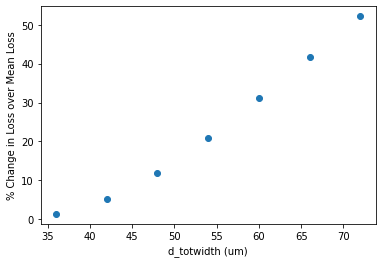

In [6]:
# More data to draw on:

zegsa_33pc_beam_exp_pcchangeinloss = fluctuation_checker(beam_exp,[[i,2*i] for i in range(12,26,2)])
zegsa_66pc_beam_exp_pcchangeinloss = fluctuation_checker(beam_exp,[[2*i,i] for i in range(12,26,2)])

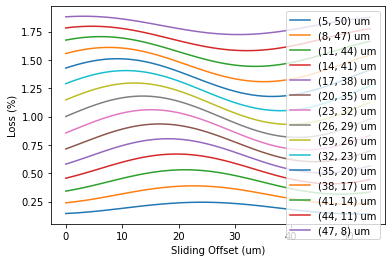

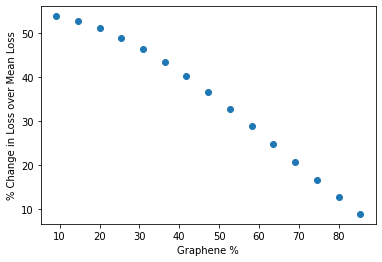

In [8]:
# Now we can modify the checker function to look for the change in loss over mean loss as we keep the width constant and increase graphene percentage

fluctuation_checker(beam_exp, [[i,55-i] for i in range(5,50,3)])

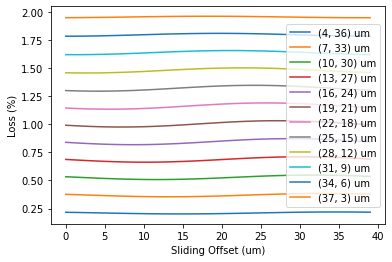

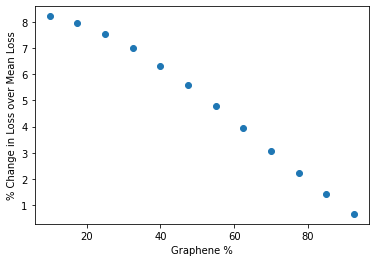

In [4]:
# Seems linear above 25% graphene, which is no problem as experimentally, layers with less than 25% graphene are
# not useful for mode-locking (Morova et al. 2020)

# Let us repeat this with d_tot = 40

fluctuation_checker(beam_exp, [[i,40-i] for i in range(4,40,3)])

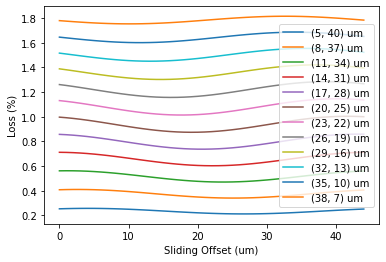

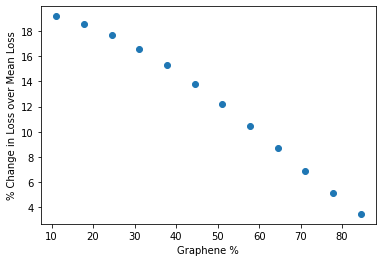

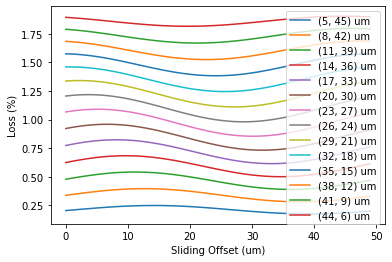

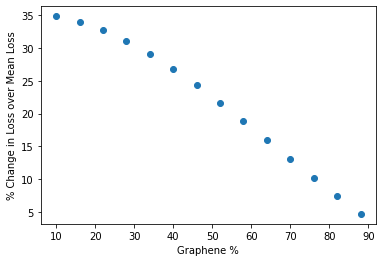

In [6]:
# Let us repeat this with d_tot = 45, 50 and try to trace how two different %_grp case behaves, maybe 40% and 80%,
# as we change d_tot and try to fit some rough estimate of slopes, then refine the approximations

# If we succeed in predicting the behavior around d_tot in [w,2w(maybe 3w??)], then
# we can then check beams of different E_p values, and then also count in ellipticity to finalize our work

fluctuation_checker(beam_exp, [[i,45-i] for i in range(5,40,3)])
fluctuation_checker(beam_exp, [[i,50-i] for i in range(5,45,3)])

## Updated Hypothesis:

By these plots, we can see a pattern for % change in loss over mean loss as:

(P:= change ratio function (x100 equals pc change), G:= % graphene)

$P=0$ if $d_{tot}<w$

$P(d_{tot},w,G_{\%}) \approx c\frac{d_{tot}-w}{w}(1-G_{\%})$ if $d_{tot}>w$ and $G_{\%}>25\%$; 

By linear regression on 33% and 66% graphene cases with various $d_{tot}$ values, $c \approx 1.2$

$$E_{after} \approx (E_p - E_{loss,epsiloncase})\cdot(1+P(d_{tot},w,G)/2)\cdot\sin(2\pi \frac{x}{d_{tot}}) )$$

For $d_{tot}>w$ and $G_{\%}>25\%$ this becomes:

$$E_{after} \approx (E_p - G_{\%} \iint_{-\infty}^{\infty}\Delta Jdxdy)\cdot(1+0.6\frac{d_{tot}-w}{w}(1-G_{\%}))\cdot\sin(2\pi \frac{x}{d_{tot}}) )$$

$c = 1.2$ underestimates fluctuation for $w<d_{tot}<2w$ and overestimates above 2w cases

There is non-linearity near $d_{tot} \approx w$ and when $d_{tot} > 3w$

As a next step, we need to check whether the constant $c$ actually holds for cases other than those that have already been tried, whether $c$ depends on $E_p$, and experiment with ellipticity.